In [4]:
from autogluon.tabular import TabularDataset, TabularPredictor

# import DiCE
import dice_ml
from dice_ml import Dice
import sklearn
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris, fetch_california_housing
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

import pandas as pd
import random
import numpy as np
from IPython.display import display, HTML

from sklearn.ensemble import IsolationForest

import load_data

import importlib
importlib.reload(load_data)

<module 'load_data' from 'C:\\Users\\Lyle\\Documents\\DeCoDE\\Files for Yazan\\load_data.py'>

In [6]:
x_scaled, y, _, xscaler = load_data.load_framed_dataset("r", onehot = True, scaled = True, augmented = True)
    
#Filter top n% of values
q = y.quantile(.95)
for col in y.columns:
    y=y[y[col] <= q[col]]
x_scaled=x_scaled.loc[y.index]
    
yscaler = StandardScaler()
yscaler.fit(y)
y_scaled = yscaler.transform(y)
y_scaled=pd.DataFrame(y_scaled, columns=y.columns, index=y.index)

print(x_scaled)
print(y_scaled)

           Material=Steel  Material=Aluminum  Material=Titanium  SSB_Include  \
1                0.827145          -0.465079           -0.54407    -0.945015   
2               -1.208978           2.150174           -0.54407    -0.945015   
4                0.827145          -0.465079           -0.54407    -0.945015   
5                0.827145          -0.465079           -0.54407    -0.945015   
8               -1.208978           2.150174           -0.54407    -0.945015   
...                   ...                ...                ...          ...   
Gen 10798        0.827145          -0.465079           -0.54407    -0.945015   
Gen 10801        0.827145          -0.465079           -0.54407    -0.945015   
Gen 10802        0.827145          -0.465079           -0.54407     1.058185   
Gen 10803       -1.208978          -0.465079            1.83800     1.058185   
Gen 10804        0.827145          -0.465079           -0.54407     1.058185   

           CSB_Include  CS Length   BB 

In [30]:
from autogluon.tabular import TabularDataset, TabularPredictor
from autogluon.common.utils.utils import setup_outputdir
from autogluon.core.utils.loaders import load_pkl
from autogluon.core.utils.savers import save_pkl
import os.path

class MultilabelPredictor():
    """ Tabular Predictor for predicting multiple columns in table.
        Creates multiple TabularPredictor objects which you can also use individually.
        You can access the TabularPredictor for a particular label via: `multilabel_predictor.get_predictor(label_i)`

        Parameters
        ----------
        labels : List[str]
            The ith element of this list is the column (i.e. `label`) predicted by the ith TabularPredictor stored in this object.
        path : str, default = None
            Path to directory where models and intermediate outputs should be saved.
            If unspecified, a time-stamped folder called "AutogluonModels/ag-[TIMESTAMP]" will be created in the working directory to store all models.
            Note: To call `fit()` twice and save all results of each fit, you must specify different `path` locations or don't specify `path` at all.
            Otherwise files from first `fit()` will be overwritten by second `fit()`.
            Caution: when predicting many labels, this directory may grow large as it needs to store many TabularPredictors.
        problem_types : List[str], default = None
            The ith element is the `problem_type` for the ith TabularPredictor stored in this object.
        eval_metrics : List[str], default = None
            The ith element is the `eval_metric` for the ith TabularPredictor stored in this object.
        consider_labels_correlation : bool, default = True
            Whether the predictions of multiple labels should account for label correlations or predict each label independently of the others.
            If True, the ordering of `labels` may affect resulting accuracy as each label is predicted conditional on the previous labels appearing earlier in this list (i.e. in an auto-regressive fashion).
            Set to False if during inference you may want to individually use just the ith TabularPredictor without predicting all the other labels.
        kwargs :
            Arguments passed into the initialization of each TabularPredictor.

    """

    multi_predictor_file = 'multilabel_predictor.pkl'

    def __init__(self, labels, path=None, problem_types=None, eval_metrics=None, consider_labels_correlation=True, **kwargs):
        if len(labels) < 2:
            raise ValueError("MultilabelPredictor is only intended for predicting MULTIPLE labels (columns), use TabularPredictor for predicting one label (column).")
        if (problem_types is not None) and (len(problem_types) != len(labels)):
            raise ValueError("If provided, `problem_types` must have same length as `labels`")
        if (eval_metrics is not None) and (len(eval_metrics) != len(labels)):
            raise ValueError("If provided, `eval_metrics` must have same length as `labels`")
        self.path = setup_outputdir(path, warn_if_exist=False)
        self.labels = labels
        self.consider_labels_correlation = consider_labels_correlation
        self.predictors = {}  # key = label, value = TabularPredictor or str path to the TabularPredictor for this label
        if eval_metrics is None:
            self.eval_metrics = {}
        else:
            self.eval_metrics = {labels[i] : eval_metrics[i] for i in range(len(labels))}
        problem_type = None
        eval_metric = None
        for i in range(len(labels)):
            label = labels[i]
            path_i = self.path + "Predictor_" + label
            if problem_types is not None:
                problem_type = problem_types[i]
            if eval_metrics is not None:
                eval_metric = eval_metrics[i]
            self.predictors[label] = TabularPredictor(label=label, problem_type=problem_type, eval_metric=eval_metric, path=path_i, **kwargs)

    def fit(self, train_data, tuning_data=None, **kwargs):
        """ Fits a separate TabularPredictor to predict each of the labels.

            Parameters
            ----------
            train_data, tuning_data : str or autogluon.tabular.TabularDataset or pd.DataFrame
                See documentation for `TabularPredictor.fit()`.
            kwargs :
                Arguments passed into the `fit()` call for each TabularPredictor.
        """
        if isinstance(train_data, str):
            train_data = TabularDataset(train_data)
        if tuning_data is not None and isinstance(tuning_data, str):
            tuning_data = TabularDataset(tuning_data)
        train_data_og = train_data.copy()
        if tuning_data is not None:
            tuning_data_og = tuning_data.copy()
        else:
            tuning_data_og = None
        save_metrics = len(self.eval_metrics) == 0
        for i in range(len(self.labels)):
            label = self.labels[i]
            predictor = self.get_predictor(label)
            if not self.consider_labels_correlation:
                labels_to_drop = [l for l in self.labels if l != label]
            else:
                labels_to_drop = [self.labels[j] for j in range(i+1, len(self.labels))]
            train_data = train_data_og.drop(labels_to_drop, axis=1)
            if tuning_data is not None:
                tuning_data = tuning_data_og.drop(labels_to_drop, axis=1)
            print(f"Fitting TabularPredictor for label: {label} ...")
            predictor.fit(train_data=train_data, tuning_data=tuning_data, **kwargs)
            self.predictors[label] = predictor.path
            if save_metrics:
                self.eval_metrics[label] = predictor.eval_metric
        self.save()

    def predict(self, data, **kwargs):
        """ Returns DataFrame with label columns containing predictions for each label.

            Parameters
            ----------
            data : str or autogluon.tabular.TabularDataset or pd.DataFrame
                Data to make predictions for. If label columns are present in this data, they will be ignored. See documentation for `TabularPredictor.predict()`.
            kwargs :
                Arguments passed into the predict() call for each TabularPredictor.
        """
        return self._predict(data, as_proba=False, **kwargs)

    def predict_proba(self, data, **kwargs):
        """ Returns dict where each key is a label and the corresponding value is the `predict_proba()` output for just that label.

            Parameters
            ----------
            data : str or autogluon.tabular.TabularDataset or pd.DataFrame
                Data to make predictions for. See documentation for `TabularPredictor.predict()` and `TabularPredictor.predict_proba()`.
            kwargs :
                Arguments passed into the `predict_proba()` call for each TabularPredictor (also passed into a `predict()` call).
        """
        return self._predict(data, as_proba=True, **kwargs)

    def evaluate(self, data, **kwargs):
        """ Returns dict where each key is a label and the corresponding value is the `evaluate()` output for just that label.

            Parameters
            ----------
            data : str or autogluon.tabular.TabularDataset or pd.DataFrame
                Data to evalate predictions of all labels for, must contain all labels as columns. See documentation for `TabularPredictor.evaluate()`.
            kwargs :
                Arguments passed into the `evaluate()` call for each TabularPredictor (also passed into the `predict()` call).
        """
        data = self._get_data(data)
        eval_dict = {}
        for label in self.labels:
            print(f"Evaluating TabularPredictor for label: {label} ...")
            predictor = self.get_predictor(label)
            eval_dict[label] = predictor.evaluate(data, **kwargs)
            if self.consider_labels_correlation:
                data[label] = predictor.predict(data, **kwargs)
        return eval_dict

    def save(self):
        """ Save MultilabelPredictor to disk. """
        for label in self.labels:
            if not isinstance(self.predictors[label], str):
                self.predictors[label] = self.predictors[label].path
        save_pkl.save(path=self.path+self.multi_predictor_file, object=self)
        print(f"MultilabelPredictor saved to disk. Load with: MultilabelPredictor.load('{self.path}')")

    @classmethod
    def load(cls, path):
        """ Load MultilabelPredictor from disk `path` previously specified when creating this MultilabelPredictor. """
        path = os.path.expanduser(path)
        if path[-1] != os.path.sep:
            path = path + os.path.sep
        return load_pkl.load(path=path+cls.multi_predictor_file)

    def get_predictor(self, label):
        """ Returns TabularPredictor which is used to predict this label. """
        predictor = self.predictors[label]
        if isinstance(predictor, str):
            return TabularPredictor.load(path=predictor)
        return predictor

    def _get_data(self, data):
        if isinstance(data, str):
            return TabularDataset(data)
        return data.copy()

    def _predict(self, data, as_proba=False, **kwargs):
        data = self._get_data(data)
        if as_proba:
            predproba_dict = {}
        for label in self.labels:
#             print(f"Predicting with TabularPredictor for label: {label} ...")
            predictor = self.get_predictor(label)
            if as_proba:
                predproba_dict[label] = predictor.predict_proba(data, as_multiclass=True, **kwargs)
            data[label] = predictor.predict(data, **kwargs)
        if not as_proba:
            return data[self.labels]
        else:
            return predproba_dict

In [31]:
# x_scaled=pd.DataFrame(x_scaled, columns=x.columns, index=x.index)

# print(data)
continuous_features=['CS Length', 'BB Drop', 'Stack', 'SS E',
       'ST Angle', 'BB OD', 'TT OD', 'HT OD', 'DT OD', 'CS OD', 'SS OD',
       'ST OD', 'CS F', 'HT LX', 'ST UX', 'HT UX', 'HT Angle', 'HT Length',
       'ST Length', 'BB Length', 'Dropout Offset', 'SSB OD', 'CSB OD',
       'SSB Offset', 'CSB Offset', 'SS Z', 'SS Thickness', 'CS Thickness',
       'TT Thickness', 'BB Thickness', 'HT Thickness', 'ST Thickness',
       'DT Thickness', 'DT Length']
categorical = x.columns.difference(continuous_features)
for col in categorical:
    x[col] = x[col].astype(str)
xdata=x_scaled
ydata=y_scaled
data=pd.concat([xdata, ydata], axis=1)
data_train, data_test, y_train, y_test=train_test_split(data, ydata, test_size=0.2, random_state=2021)
x_train, x_test, y_train, y_test=train_test_split(xdata, ydata, test_size=0.2, random_state=2021)

In [32]:
print(ydata)
print(ydata[ydata.isnull().any(axis=1)])

          Sim 1 Dropout X Disp.  Sim 1 Dropout Y Disp.  \
Gen 243                0.056326              -0.237619   
Gen 4190              -0.631268              -0.774096   
Gen 1250              -0.906003              -0.819917   
Gen 6983              -1.128816              -1.102000   
Gen 9888              -0.158481              -0.068686   
...                         ...                    ...   
Gen 5004              -0.121594              -0.251504   
Gen 9242              -0.992694              -0.958303   
Gen 545               -0.457769              -0.767964   
Gen 8049               0.469418               0.181821   
Gen 7135              -0.719006              -0.718730   

          Sim 1 Bottom Bracket X Disp.  Sim 1 Bottom Bracket Y Disp.  \
Gen 243                       0.052782                     -0.430845   
Gen 4190                     -0.672639                     -0.864204   
Gen 1250                     -0.875664                     -0.788121   
Gen 6983       

In [33]:
labels=y.columns
predictor = MultilabelPredictor(labels=labels)
predictor.fit(train_data=data_train)

Beginning AutoGluon training ...
AutoGluon will save models to "AutogluonModels/ag-20220622_012039\Predictor_Sim 1 Dropout X Disp.\"
AutoGluon Version:  0.4.0
Python Version:     3.8.12
Operating System:   Windows
Train Data Rows:    9656
Train Data Columns: 39
Label Column: Sim 1 Dropout X Disp.
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == float and many unique label-values observed).
	Label info (max, min, mean, stddev): (3.7822966812497514, -1.1989074766447465, 0.00278, 1.00178)
	If 'regression' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    18001.84 MB
	Train Data (Original)  Memory Usage: 3.01 MB (0.0% of available memory)
	Inferring data type o

Fitting TabularPredictor for label: Sim 1 Dropout X Disp. ...


	-0.6385	 = Validation score   (root_mean_squared_error)
	0.01s	 = Training   runtime
	0.13s	 = Validation runtime
Fitting model: KNeighborsDist ...
	-0.6107	 = Validation score   (root_mean_squared_error)
	0.01s	 = Training   runtime
	0.13s	 = Validation runtime
Fitting model: LightGBMXT ...


[1000]	valid_set's rmse: 0.220446
[2000]	valid_set's rmse: 0.215999
[3000]	valid_set's rmse: 0.214561
[4000]	valid_set's rmse: 0.213877
[5000]	valid_set's rmse: 0.213756


	-0.2137	 = Validation score   (root_mean_squared_error)
	8.29s	 = Training   runtime
	0.02s	 = Validation runtime
Fitting model: LightGBM ...


[1000]	valid_set's rmse: 0.198829


	-0.1985	 = Validation score   (root_mean_squared_error)
	1.19s	 = Training   runtime
	0.01s	 = Validation runtime
Fitting model: RandomForestMSE ...
	-0.2554	 = Validation score   (root_mean_squared_error)
	2.99s	 = Training   runtime
	0.04s	 = Validation runtime
Fitting model: CatBoost ...
	-0.1773	 = Validation score   (root_mean_squared_error)
	69.93s	 = Training   runtime
	0.01s	 = Validation runtime
Fitting model: ExtraTreesMSE ...
	-0.3014	 = Validation score   (root_mean_squared_error)
	0.94s	 = Training   runtime
	0.04s	 = Validation runtime
Fitting model: NeuralNetFastAI ...
	-0.2377	 = Validation score   (root_mean_squared_error)
	8.62s	 = Training   runtime
	0.03s	 = Validation runtime
Fitting model: XGBoost ...
	-0.2053	 = Validation score   (root_mean_squared_error)
	6.04s	 = Training   runtime
	0.01s	 = Validation runtime
Fitting model: NeuralNetTorch ...
	-0.2649	 = Validation score   (root_mean_squared_error)
	26.32s	 = Training   runtime
	0.03s	 = Validation runtime
F

[1000]	valid_set's rmse: 0.200427
[2000]	valid_set's rmse: 0.200306


	-0.2003	 = Validation score   (root_mean_squared_error)
	6.79s	 = Training   runtime
	0.02s	 = Validation runtime
Fitting model: WeightedEnsemble_L2 ...
	-0.1728	 = Validation score   (root_mean_squared_error)
	0.21s	 = Training   runtime
	0.0s	 = Validation runtime
AutoGluon training complete, total runtime = 134.27s ... Best model: "WeightedEnsemble_L2"
TabularPredictor saved. To load, use: predictor = TabularPredictor.load("AutogluonModels/ag-20220622_012039\Predictor_Sim 1 Dropout X Disp.\")
Beginning AutoGluon training ...
AutoGluon will save models to "AutogluonModels/ag-20220622_012039\Predictor_Sim 1 Dropout Y Disp.\"
AutoGluon Version:  0.4.0
Python Version:     3.8.12
Operating System:   Windows
Train Data Rows:    9656
Train Data Columns: 40
Label Column: Sim 1 Dropout Y Disp.
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == float and many unique label-values observed).
	Label info (max, min, mean, stddev): (

Fitting TabularPredictor for label: Sim 1 Dropout Y Disp. ...


	-0.3591	 = Validation score   (root_mean_squared_error)
	0.01s	 = Training   runtime
	0.14s	 = Validation runtime
Fitting model: KNeighborsDist ...
	-0.3428	 = Validation score   (root_mean_squared_error)
	0.01s	 = Training   runtime
	0.13s	 = Validation runtime
Fitting model: LightGBMXT ...


[1000]	valid_set's rmse: 0.0770608
[2000]	valid_set's rmse: 0.0753311
[3000]	valid_set's rmse: 0.0748441
[4000]	valid_set's rmse: 0.0746875
[5000]	valid_set's rmse: 0.0745256
[6000]	valid_set's rmse: 0.074489
[7000]	valid_set's rmse: 0.074467
[8000]	valid_set's rmse: 0.0744468
[9000]	valid_set's rmse: 0.0744469


	-0.0744	 = Validation score   (root_mean_squared_error)
	7.94s	 = Training   runtime
	0.04s	 = Validation runtime
Fitting model: LightGBM ...


[1000]	valid_set's rmse: 0.0721071


	-0.072	 = Validation score   (root_mean_squared_error)
	1.59s	 = Training   runtime
	0.02s	 = Validation runtime
Fitting model: RandomForestMSE ...
	-0.1084	 = Validation score   (root_mean_squared_error)
	3.14s	 = Training   runtime
	0.04s	 = Validation runtime
Fitting model: CatBoost ...
	-0.0667	 = Validation score   (root_mean_squared_error)
	4.84s	 = Training   runtime
	0.0s	 = Validation runtime
Fitting model: ExtraTreesMSE ...
	-0.1132	 = Validation score   (root_mean_squared_error)
	1.02s	 = Training   runtime
	0.04s	 = Validation runtime
Fitting model: NeuralNetFastAI ...
	-0.1164	 = Validation score   (root_mean_squared_error)
	7.42s	 = Training   runtime
	0.02s	 = Validation runtime
Fitting model: XGBoost ...
	-0.0733	 = Validation score   (root_mean_squared_error)
	4.34s	 = Training   runtime
	0.01s	 = Validation runtime
Fitting model: NeuralNetTorch ...
	-0.0836	 = Validation score   (root_mean_squared_error)
	29.42s	 = Training   runtime
	0.03s	 = Validation runtime
Fitt

[1000]	valid_set's rmse: 0.0823896


	-0.0824	 = Validation score   (root_mean_squared_error)
	4.53s	 = Training   runtime
	0.02s	 = Validation runtime
Fitting model: WeightedEnsemble_L2 ...
	-0.0587	 = Validation score   (root_mean_squared_error)
	0.21s	 = Training   runtime
	0.0s	 = Validation runtime
AutoGluon training complete, total runtime = 67.8s ... Best model: "WeightedEnsemble_L2"
TabularPredictor saved. To load, use: predictor = TabularPredictor.load("AutogluonModels/ag-20220622_012039\Predictor_Sim 1 Dropout Y Disp.\")
Beginning AutoGluon training ...
AutoGluon will save models to "AutogluonModels/ag-20220622_012039\Predictor_Sim 1 Bottom Bracket X Disp.\"
AutoGluon Version:  0.4.0
Python Version:     3.8.12
Operating System:   Windows
Train Data Rows:    9656
Train Data Columns: 41
Label Column: Sim 1 Bottom Bracket X Disp.
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == float and many unique label-values observed).
	Label info (max, min, mean

Fitting TabularPredictor for label: Sim 1 Bottom Bracket X Disp. ...


	-0.288	 = Validation score   (root_mean_squared_error)
	0.02s	 = Training   runtime
	0.13s	 = Validation runtime
Fitting model: KNeighborsDist ...
	-0.2717	 = Validation score   (root_mean_squared_error)
	0.01s	 = Training   runtime
	0.13s	 = Validation runtime
Fitting model: LightGBMXT ...


[1000]	valid_set's rmse: 0.040323
[2000]	valid_set's rmse: 0.0387504
[3000]	valid_set's rmse: 0.0384425
[4000]	valid_set's rmse: 0.0382922
[5000]	valid_set's rmse: 0.038234
[6000]	valid_set's rmse: 0.038214
[7000]	valid_set's rmse: 0.0381927
[8000]	valid_set's rmse: 0.0381822
[9000]	valid_set's rmse: 0.0381738
[10000]	valid_set's rmse: 0.0381729


	-0.0382	 = Validation score   (root_mean_squared_error)
	8.24s	 = Training   runtime
	0.06s	 = Validation runtime
Fitting model: LightGBM ...
	-0.0215	 = Validation score   (root_mean_squared_error)
	0.72s	 = Training   runtime
	0.01s	 = Validation runtime
Fitting model: RandomForestMSE ...
	-0.0292	 = Validation score   (root_mean_squared_error)
	2.99s	 = Training   runtime
	0.04s	 = Validation runtime
Fitting model: CatBoost ...
	-0.0223	 = Validation score   (root_mean_squared_error)
	70.45s	 = Training   runtime
	0.0s	 = Validation runtime
Fitting model: ExtraTreesMSE ...
	-0.0282	 = Validation score   (root_mean_squared_error)
	1.01s	 = Training   runtime
	0.04s	 = Validation runtime
Fitting model: NeuralNetFastAI ...
	-0.0241	 = Validation score   (root_mean_squared_error)
	7.63s	 = Training   runtime
	0.02s	 = Validation runtime
Fitting model: XGBoost ...
	-0.0216	 = Validation score   (root_mean_squared_error)
	3.02s	 = Training   runtime
	0.01s	 = Validation runtime
Fitting m

[1000]	valid_set's rmse: 0.0271373


	-0.0271	 = Validation score   (root_mean_squared_error)
	5.42s	 = Training   runtime
	0.01s	 = Validation runtime
Fitting model: WeightedEnsemble_L2 ...
	-0.0173	 = Validation score   (root_mean_squared_error)
	0.21s	 = Training   runtime
	0.0s	 = Validation runtime
AutoGluon training complete, total runtime = 129.02s ... Best model: "WeightedEnsemble_L2"
TabularPredictor saved. To load, use: predictor = TabularPredictor.load("AutogluonModels/ag-20220622_012039\Predictor_Sim 1 Bottom Bracket X Disp.\")
Beginning AutoGluon training ...
AutoGluon will save models to "AutogluonModels/ag-20220622_012039\Predictor_Sim 1 Bottom Bracket Y Disp.\"
AutoGluon Version:  0.4.0
Python Version:     3.8.12
Operating System:   Windows
Train Data Rows:    9656
Train Data Columns: 42
Label Column: Sim 1 Bottom Bracket Y Disp.
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == float and many unique label-values observed).
	Label info (max, 

Fitting TabularPredictor for label: Sim 1 Bottom Bracket Y Disp. ...


	-0.2895	 = Validation score   (root_mean_squared_error)
	0.02s	 = Training   runtime
	0.14s	 = Validation runtime
Fitting model: KNeighborsDist ...
	-0.2757	 = Validation score   (root_mean_squared_error)
	0.02s	 = Training   runtime
	0.13s	 = Validation runtime
Fitting model: LightGBMXT ...


[1000]	valid_set's rmse: 0.0642551
[2000]	valid_set's rmse: 0.0623983
[3000]	valid_set's rmse: 0.0618336
[4000]	valid_set's rmse: 0.0616837
[5000]	valid_set's rmse: 0.0615623
[6000]	valid_set's rmse: 0.0615499
[7000]	valid_set's rmse: 0.0615303
[8000]	valid_set's rmse: 0.0615176
[9000]	valid_set's rmse: 0.0615125
[10000]	valid_set's rmse: 0.0615124


	-0.0615	 = Validation score   (root_mean_squared_error)
	8.14s	 = Training   runtime
	0.05s	 = Validation runtime
Fitting model: LightGBM ...
	-0.0567	 = Validation score   (root_mean_squared_error)
	0.66s	 = Training   runtime
	0.01s	 = Validation runtime
Fitting model: RandomForestMSE ...
	-0.068	 = Validation score   (root_mean_squared_error)
	3.23s	 = Training   runtime
	0.04s	 = Validation runtime
Fitting model: CatBoost ...
	-0.0581	 = Validation score   (root_mean_squared_error)
	71.34s	 = Training   runtime
	0.0s	 = Validation runtime
Fitting model: ExtraTreesMSE ...
	-0.0647	 = Validation score   (root_mean_squared_error)
	1.03s	 = Training   runtime
	0.04s	 = Validation runtime
Fitting model: NeuralNetFastAI ...
	-0.0815	 = Validation score   (root_mean_squared_error)
	7.53s	 = Training   runtime
	0.02s	 = Validation runtime
Fitting model: XGBoost ...
	-0.0466	 = Validation score   (root_mean_squared_error)
	3.86s	 = Training   runtime
	0.01s	 = Validation runtime
Fitting mo

Fitting TabularPredictor for label: Sim 2 Bottom Bracket Z Disp. ...


	-0.6388	 = Validation score   (root_mean_squared_error)
	0.02s	 = Training   runtime
	0.13s	 = Validation runtime
Fitting model: KNeighborsDist ...
	-0.6064	 = Validation score   (root_mean_squared_error)
	0.02s	 = Training   runtime
	0.14s	 = Validation runtime
Fitting model: LightGBMXT ...


[1000]	valid_set's rmse: 0.209341
[2000]	valid_set's rmse: 0.207762


	-0.2074	 = Validation score   (root_mean_squared_error)
	2.03s	 = Training   runtime
	0.02s	 = Validation runtime
Fitting model: LightGBM ...


[1000]	valid_set's rmse: 0.211554
[2000]	valid_set's rmse: 0.211031
[3000]	valid_set's rmse: 0.21065
[4000]	valid_set's rmse: 0.210546
[5000]	valid_set's rmse: 0.210509
[6000]	valid_set's rmse: 0.210487
[7000]	valid_set's rmse: 0.210478
[8000]	valid_set's rmse: 0.210475
[9000]	valid_set's rmse: 0.210476
[10000]	valid_set's rmse: 0.210476


	-0.2105	 = Validation score   (root_mean_squared_error)
	8.47s	 = Training   runtime
	0.07s	 = Validation runtime
Fitting model: RandomForestMSE ...
	-0.3322	 = Validation score   (root_mean_squared_error)
	3.49s	 = Training   runtime
	0.04s	 = Validation runtime
Fitting model: CatBoost ...
	-0.1766	 = Validation score   (root_mean_squared_error)
	71.13s	 = Training   runtime
	0.0s	 = Validation runtime
Fitting model: ExtraTreesMSE ...
	-0.333	 = Validation score   (root_mean_squared_error)
	1.0s	 = Training   runtime
	0.04s	 = Validation runtime
Fitting model: NeuralNetFastAI ...
	-0.1685	 = Validation score   (root_mean_squared_error)
	7.6s	 = Training   runtime
	0.02s	 = Validation runtime
Fitting model: XGBoost ...
	-0.2195	 = Validation score   (root_mean_squared_error)
	6.53s	 = Training   runtime
	0.01s	 = Validation runtime
Fitting model: NeuralNetTorch ...
	-0.2083	 = Validation score   (root_mean_squared_error)
	44.09s	 = Training   runtime
	0.03s	 = Validation runtime
Fitti

[1000]	valid_set's rmse: 0.235916
[2000]	valid_set's rmse: 0.235742
[3000]	valid_set's rmse: 0.235732
[4000]	valid_set's rmse: 0.23573
[5000]	valid_set's rmse: 0.23573
[6000]	valid_set's rmse: 0.23573
[7000]	valid_set's rmse: 0.23573
[8000]	valid_set's rmse: 0.23573
[9000]	valid_set's rmse: 0.23573


	-0.2357	 = Validation score   (root_mean_squared_error)
	27.69s	 = Training   runtime
	0.09s	 = Validation runtime
Fitting model: WeightedEnsemble_L2 ...
	-0.1565	 = Validation score   (root_mean_squared_error)
	0.21s	 = Training   runtime
	0.0s	 = Validation runtime
AutoGluon training complete, total runtime = 176.73s ... Best model: "WeightedEnsemble_L2"
TabularPredictor saved. To load, use: predictor = TabularPredictor.load("AutogluonModels/ag-20220622_012039\Predictor_Sim 2 Bottom Bracket Z Disp.\")
Beginning AutoGluon training ...
AutoGluon will save models to "AutogluonModels/ag-20220622_012039\Predictor_Sim 3 Bottom Bracket Y Disp.\"
AutoGluon Version:  0.4.0
Python Version:     3.8.12
Operating System:   Windows
Train Data Rows:    9656
Train Data Columns: 44
Label Column: Sim 3 Bottom Bracket Y Disp.
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == float and many unique label-values observed).
	Label info (max,

Fitting TabularPredictor for label: Sim 3 Bottom Bracket Y Disp. ...


	-0.4331	 = Validation score   (root_mean_squared_error)
	0.02s	 = Training   runtime
	0.13s	 = Validation runtime
Fitting model: KNeighborsDist ...
	-0.4091	 = Validation score   (root_mean_squared_error)
	0.02s	 = Training   runtime
	0.13s	 = Validation runtime
Fitting model: LightGBMXT ...


[1000]	valid_set's rmse: 0.168428
[2000]	valid_set's rmse: 0.163574
[3000]	valid_set's rmse: 0.162356
[4000]	valid_set's rmse: 0.161918
[5000]	valid_set's rmse: 0.161762
[6000]	valid_set's rmse: 0.161642
[7000]	valid_set's rmse: 0.161579
[8000]	valid_set's rmse: 0.16156
[9000]	valid_set's rmse: 0.161529
[10000]	valid_set's rmse: 0.161518


	-0.1615	 = Validation score   (root_mean_squared_error)
	7.71s	 = Training   runtime
	0.06s	 = Validation runtime
Fitting model: LightGBM ...


[1000]	valid_set's rmse: 0.156124
[2000]	valid_set's rmse: 0.15496
[3000]	valid_set's rmse: 0.154756
[4000]	valid_set's rmse: 0.154633
[5000]	valid_set's rmse: 0.154597
[6000]	valid_set's rmse: 0.154573
[7000]	valid_set's rmse: 0.154569
[8000]	valid_set's rmse: 0.154565
[9000]	valid_set's rmse: 0.154564
[10000]	valid_set's rmse: 0.154564


	-0.1546	 = Validation score   (root_mean_squared_error)
	8.46s	 = Training   runtime
	0.05s	 = Validation runtime
Fitting model: RandomForestMSE ...
	-0.1593	 = Validation score   (root_mean_squared_error)
	3.28s	 = Training   runtime
	0.04s	 = Validation runtime
Fitting model: CatBoost ...
	-0.1379	 = Validation score   (root_mean_squared_error)
	71.11s	 = Training   runtime
	0.0s	 = Validation runtime
Fitting model: ExtraTreesMSE ...
	-0.1861	 = Validation score   (root_mean_squared_error)
	1.04s	 = Training   runtime
	0.04s	 = Validation runtime
Fitting model: NeuralNetFastAI ...
	-0.1093	 = Validation score   (root_mean_squared_error)
	7.56s	 = Training   runtime
	0.02s	 = Validation runtime
Fitting model: XGBoost ...
	-0.142	 = Validation score   (root_mean_squared_error)
	5.44s	 = Training   runtime
	0.01s	 = Validation runtime
Fitting model: NeuralNetTorch ...
	-0.1775	 = Validation score   (root_mean_squared_error)
	44.8s	 = Training   runtime
	0.03s	 = Validation runtime
Fitt

[1000]	valid_set's rmse: 0.177979


	-0.178	 = Validation score   (root_mean_squared_error)
	3.98s	 = Training   runtime
	0.01s	 = Validation runtime
Fitting model: WeightedEnsemble_L2 ...
	-0.1047	 = Validation score   (root_mean_squared_error)
	0.22s	 = Training   runtime
	0.0s	 = Validation runtime
AutoGluon training complete, total runtime = 158.19s ... Best model: "WeightedEnsemble_L2"
TabularPredictor saved. To load, use: predictor = TabularPredictor.load("AutogluonModels/ag-20220622_012039\Predictor_Sim 3 Bottom Bracket Y Disp.\")
Beginning AutoGluon training ...
AutoGluon will save models to "AutogluonModels/ag-20220622_012039\Predictor_Sim 3 Bottom Bracket X Rot.\"
AutoGluon Version:  0.4.0
Python Version:     3.8.12
Operating System:   Windows
Train Data Rows:    9656
Train Data Columns: 45
Label Column: Sim 3 Bottom Bracket X Rot.
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == float and many unique label-values observed).
	Label info (max, min

Fitting TabularPredictor for label: Sim 3 Bottom Bracket X Rot. ...


	-0.4652	 = Validation score   (root_mean_squared_error)
	0.02s	 = Training   runtime
	0.13s	 = Validation runtime
Fitting model: KNeighborsDist ...
	-0.4409	 = Validation score   (root_mean_squared_error)
	0.02s	 = Training   runtime
	0.14s	 = Validation runtime
Fitting model: LightGBMXT ...


[1000]	valid_set's rmse: 0.152708
[2000]	valid_set's rmse: 0.14701
[3000]	valid_set's rmse: 0.145188
[4000]	valid_set's rmse: 0.144455
[5000]	valid_set's rmse: 0.144033
[6000]	valid_set's rmse: 0.143903
[7000]	valid_set's rmse: 0.143872
[8000]	valid_set's rmse: 0.143851
[9000]	valid_set's rmse: 0.143796
[10000]	valid_set's rmse: 0.143778


	-0.1438	 = Validation score   (root_mean_squared_error)
	7.85s	 = Training   runtime
	0.05s	 = Validation runtime
Fitting model: LightGBM ...


[1000]	valid_set's rmse: 0.172933
[2000]	valid_set's rmse: 0.171692
[3000]	valid_set's rmse: 0.171259
[4000]	valid_set's rmse: 0.171133
[5000]	valid_set's rmse: 0.17112


	-0.1711	 = Validation score   (root_mean_squared_error)
	5.01s	 = Training   runtime
	0.03s	 = Validation runtime
Fitting model: RandomForestMSE ...
	-0.239	 = Validation score   (root_mean_squared_error)
	3.65s	 = Training   runtime
	0.04s	 = Validation runtime
Fitting model: CatBoost ...
	-0.1414	 = Validation score   (root_mean_squared_error)
	70.35s	 = Training   runtime
	0.0s	 = Validation runtime
Fitting model: ExtraTreesMSE ...
	-0.2431	 = Validation score   (root_mean_squared_error)
	1.06s	 = Training   runtime
	0.04s	 = Validation runtime
Fitting model: NeuralNetFastAI ...
	-0.1376	 = Validation score   (root_mean_squared_error)
	7.36s	 = Training   runtime
	0.02s	 = Validation runtime
Fitting model: XGBoost ...
	-0.1845	 = Validation score   (root_mean_squared_error)
	6.39s	 = Training   runtime
	0.01s	 = Validation runtime
Fitting model: NeuralNetTorch ...
	-0.1716	 = Validation score   (root_mean_squared_error)
	38.63s	 = Training   runtime
	0.03s	 = Validation runtime
Fit

[1000]	valid_set's rmse: 0.189513
[2000]	valid_set's rmse: 0.189308
[3000]	valid_set's rmse: 0.189298
[4000]	valid_set's rmse: 0.189297
[5000]	valid_set's rmse: 0.189297
[6000]	valid_set's rmse: 0.189296
[7000]	valid_set's rmse: 0.189296
[8000]	valid_set's rmse: 0.189296


	-0.1893	 = Validation score   (root_mean_squared_error)
	25.88s	 = Training   runtime
	0.08s	 = Validation runtime
Fitting model: WeightedEnsemble_L2 ...
	-0.1245	 = Validation score   (root_mean_squared_error)
	0.21s	 = Training   runtime
	0.0s	 = Validation runtime
AutoGluon training complete, total runtime = 171.34s ... Best model: "WeightedEnsemble_L2"
TabularPredictor saved. To load, use: predictor = TabularPredictor.load("AutogluonModels/ag-20220622_012039\Predictor_Sim 3 Bottom Bracket X Rot.\")
Beginning AutoGluon training ...
AutoGluon will save models to "AutogluonModels/ag-20220622_012039\Predictor_Sim 1 Safety Factor\"
AutoGluon Version:  0.4.0
Python Version:     3.8.12
Operating System:   Windows
Train Data Rows:    9656
Train Data Columns: 46
Label Column: Sim 1 Safety Factor
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == float and many unique label-values observed).
	Label info (max, min, mean, stddev)

Fitting TabularPredictor for label: Sim 1 Safety Factor ...


	-0.5237	 = Validation score   (root_mean_squared_error)
	0.02s	 = Training   runtime
	0.13s	 = Validation runtime
Fitting model: KNeighborsDist ...
	-0.4968	 = Validation score   (root_mean_squared_error)
	0.02s	 = Training   runtime
	0.13s	 = Validation runtime
Fitting model: LightGBMXT ...


[1000]	valid_set's rmse: 0.247853
[2000]	valid_set's rmse: 0.24483
[3000]	valid_set's rmse: 0.24389
[4000]	valid_set's rmse: 0.243204
[5000]	valid_set's rmse: 0.243176
[6000]	valid_set's rmse: 0.242916
[7000]	valid_set's rmse: 0.242808
[8000]	valid_set's rmse: 0.242741
[9000]	valid_set's rmse: 0.242765
[10000]	valid_set's rmse: 0.242733


	-0.2427	 = Validation score   (root_mean_squared_error)
	7.73s	 = Training   runtime
	0.05s	 = Validation runtime
Fitting model: LightGBM ...


[1000]	valid_set's rmse: 0.255514
[2000]	valid_set's rmse: 0.254327
[3000]	valid_set's rmse: 0.254079
[4000]	valid_set's rmse: 0.254032
[5000]	valid_set's rmse: 0.254028


	-0.254	 = Validation score   (root_mean_squared_error)
	4.85s	 = Training   runtime
	0.03s	 = Validation runtime
Fitting model: RandomForestMSE ...
	-0.282	 = Validation score   (root_mean_squared_error)
	4.29s	 = Training   runtime
	0.04s	 = Validation runtime
Fitting model: CatBoost ...
	-0.2417	 = Validation score   (root_mean_squared_error)
	72.64s	 = Training   runtime
	0.0s	 = Validation runtime
Fitting model: ExtraTreesMSE ...
	-0.297	 = Validation score   (root_mean_squared_error)
	1.14s	 = Training   runtime
	0.04s	 = Validation runtime
Fitting model: NeuralNetFastAI ...
	-0.2939	 = Validation score   (root_mean_squared_error)
	7.96s	 = Training   runtime
	0.02s	 = Validation runtime
Fitting model: XGBoost ...
	-0.2658	 = Validation score   (root_mean_squared_error)
	4.76s	 = Training   runtime
	0.01s	 = Validation runtime
Fitting model: NeuralNetTorch ...
	-0.2807	 = Validation score   (root_mean_squared_error)
	35.92s	 = Training   runtime
	0.03s	 = Validation runtime
Fitti

[1000]	valid_set's rmse: 0.25155
[2000]	valid_set's rmse: 0.251438
[3000]	valid_set's rmse: 0.251428
[4000]	valid_set's rmse: 0.251428
[5000]	valid_set's rmse: 0.251428


	-0.2514	 = Validation score   (root_mean_squared_error)
	17.94s	 = Training   runtime
	0.06s	 = Validation runtime
Fitting model: WeightedEnsemble_L2 ...
	-0.2363	 = Validation score   (root_mean_squared_error)
	0.22s	 = Training   runtime
	0.0s	 = Validation runtime
AutoGluon training complete, total runtime = 162.17s ... Best model: "WeightedEnsemble_L2"
TabularPredictor saved. To load, use: predictor = TabularPredictor.load("AutogluonModels/ag-20220622_012039\Predictor_Sim 1 Safety Factor\")
Beginning AutoGluon training ...
AutoGluon will save models to "AutogluonModels/ag-20220622_012039\Predictor_Sim 3 Safety Factor\"
AutoGluon Version:  0.4.0
Python Version:     3.8.12
Operating System:   Windows
Train Data Rows:    9656
Train Data Columns: 47
Label Column: Sim 3 Safety Factor
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == float and many unique label-values observed).
	Label info (max, min, mean, stddev): (3.847

Fitting TabularPredictor for label: Sim 3 Safety Factor ...


	-0.5418	 = Validation score   (root_mean_squared_error)
	0.02s	 = Training   runtime
	0.14s	 = Validation runtime
Fitting model: KNeighborsDist ...
	-0.515	 = Validation score   (root_mean_squared_error)
	0.02s	 = Training   runtime
	0.13s	 = Validation runtime
Fitting model: LightGBMXT ...


[1000]	valid_set's rmse: 0.271338
[2000]	valid_set's rmse: 0.268558
[3000]	valid_set's rmse: 0.267108
[4000]	valid_set's rmse: 0.266812
[5000]	valid_set's rmse: 0.266787


	-0.2667	 = Validation score   (root_mean_squared_error)
	4.53s	 = Training   runtime
	0.04s	 = Validation runtime
Fitting model: LightGBM ...


[1000]	valid_set's rmse: 0.276321


	-0.2758	 = Validation score   (root_mean_squared_error)
	1.69s	 = Training   runtime
	0.01s	 = Validation runtime
Fitting model: RandomForestMSE ...
	-0.2874	 = Validation score   (root_mean_squared_error)
	4.13s	 = Training   runtime
	0.04s	 = Validation runtime
Fitting model: CatBoost ...
	-0.2627	 = Validation score   (root_mean_squared_error)
	71.07s	 = Training   runtime
	0.0s	 = Validation runtime
Fitting model: ExtraTreesMSE ...
	-0.2921	 = Validation score   (root_mean_squared_error)
	1.11s	 = Training   runtime
	0.04s	 = Validation runtime
Fitting model: NeuralNetFastAI ...
	-0.2923	 = Validation score   (root_mean_squared_error)
	7.52s	 = Training   runtime
	0.02s	 = Validation runtime
Fitting model: XGBoost ...
	-0.2775	 = Validation score   (root_mean_squared_error)
	3.38s	 = Training   runtime
	0.01s	 = Validation runtime
Fitting model: NeuralNetTorch ...
	-0.2881	 = Validation score   (root_mean_squared_error)
	27.43s	 = Training   runtime
	0.04s	 = Validation runtime
Fi

[1000]	valid_set's rmse: 0.254652
[2000]	valid_set's rmse: 0.254518
[3000]	valid_set's rmse: 0.254513


	-0.2545	 = Validation score   (root_mean_squared_error)
	9.57s	 = Training   runtime
	0.02s	 = Validation runtime
Fitting model: WeightedEnsemble_L2 ...
	-0.2477	 = Validation score   (root_mean_squared_error)
	0.21s	 = Training   runtime
	0.0s	 = Validation runtime
AutoGluon training complete, total runtime = 133.73s ... Best model: "WeightedEnsemble_L2"
TabularPredictor saved. To load, use: predictor = TabularPredictor.load("AutogluonModels/ag-20220622_012039\Predictor_Sim 3 Safety Factor\")
Beginning AutoGluon training ...
AutoGluon will save models to "AutogluonModels/ag-20220622_012039\Predictor_Model Mass\"
AutoGluon Version:  0.4.0
Python Version:     3.8.12
Operating System:   Windows
Train Data Rows:    9656
Train Data Columns: 48
Label Column: Model Mass
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == float and many unique label-values observed).
	Label info (max, min, mean, stddev): (2.2259653773061854, -1.9

Fitting TabularPredictor for label: Model Mass ...


	-0.4029	 = Validation score   (root_mean_squared_error)
	0.02s	 = Training   runtime
	0.14s	 = Validation runtime
Fitting model: KNeighborsDist ...
	-0.3685	 = Validation score   (root_mean_squared_error)
	0.02s	 = Training   runtime
	0.13s	 = Validation runtime
Fitting model: LightGBMXT ...


[1000]	valid_set's rmse: 0.13659
[2000]	valid_set's rmse: 0.129172
[3000]	valid_set's rmse: 0.127031
[4000]	valid_set's rmse: 0.126229
[5000]	valid_set's rmse: 0.1259
[6000]	valid_set's rmse: 0.125681
[7000]	valid_set's rmse: 0.125553
[8000]	valid_set's rmse: 0.125465
[9000]	valid_set's rmse: 0.125403
[10000]	valid_set's rmse: 0.125344


	-0.1253	 = Validation score   (root_mean_squared_error)
	8.06s	 = Training   runtime
	0.08s	 = Validation runtime
Fitting model: LightGBM ...


[1000]	valid_set's rmse: 0.15389
[2000]	valid_set's rmse: 0.151039
[3000]	valid_set's rmse: 0.15053
[4000]	valid_set's rmse: 0.150372
[5000]	valid_set's rmse: 0.150295
[6000]	valid_set's rmse: 0.150277
[7000]	valid_set's rmse: 0.150262
[8000]	valid_set's rmse: 0.150261
[9000]	valid_set's rmse: 0.150257
[10000]	valid_set's rmse: 0.150256


	-0.1503	 = Validation score   (root_mean_squared_error)
	8.56s	 = Training   runtime
	0.07s	 = Validation runtime
Fitting model: RandomForestMSE ...
	-0.2368	 = Validation score   (root_mean_squared_error)
	3.48s	 = Training   runtime
	0.04s	 = Validation runtime
Fitting model: CatBoost ...
	-0.1169	 = Validation score   (root_mean_squared_error)
	76.68s	 = Training   runtime
	0.0s	 = Validation runtime
Fitting model: ExtraTreesMSE ...
	-0.2253	 = Validation score   (root_mean_squared_error)
	1.12s	 = Training   runtime
	0.04s	 = Validation runtime
Fitting model: NeuralNetFastAI ...
	-0.1012	 = Validation score   (root_mean_squared_error)
	7.77s	 = Training   runtime
	0.03s	 = Validation runtime
Fitting model: XGBoost ...
	-0.1587	 = Validation score   (root_mean_squared_error)
	7.0s	 = Training   runtime
	0.01s	 = Validation runtime
Fitting model: NeuralNetTorch ...
	-0.1302	 = Validation score   (root_mean_squared_error)
	53.9s	 = Training   runtime
	0.03s	 = Validation runtime
Fitt

[1000]	valid_set's rmse: 0.17445
[2000]	valid_set's rmse: 0.174211
[3000]	valid_set's rmse: 0.1742
[4000]	valid_set's rmse: 0.1742
[5000]	valid_set's rmse: 0.174199


	-0.1742	 = Validation score   (root_mean_squared_error)
	17.75s	 = Training   runtime
	0.04s	 = Validation runtime
Fitting model: WeightedEnsemble_L2 ...
	-0.0952	 = Validation score   (root_mean_squared_error)
	0.22s	 = Training   runtime
	0.0s	 = Validation runtime
AutoGluon training complete, total runtime = 189.88s ... Best model: "WeightedEnsemble_L2"
TabularPredictor saved. To load, use: predictor = TabularPredictor.load("AutogluonModels/ag-20220622_012039\Predictor_Model Mass\")


MultilabelPredictor saved to disk. Load with: MultilabelPredictor.load('AutogluonModels/ag-20220622_012039\')


In [34]:
predictions=predictor.predict(x_test)
train_predictions=predictor.predict(x_train)
r2=sklearn.metrics.r2_score(y_test, predictions)
mse=sklearn.metrics.mean_squared_error(y_test, predictions)
mae=sklearn.metrics.mean_absolute_error(y_test, predictions)
print("R2: " + str(r2))
print("MSE: " + str(mse))
print("MAE: " + str(mae))

R2: 0.9445096245431166
MSE: 0.05452877070603508
MAE: 0.09835041567294951


In [35]:
predictions=yscaler.inverse_transform(predictions)
train_predictions=yscaler.inverse_transform(train_predictions)
y_train=yscaler.inverse_transform(y_train)
y_test=yscaler.inverse_transform(y_test)
r2=sklearn.metrics.r2_score(y_test, predictions)
mse=sklearn.metrics.mean_squared_error(y_test, predictions)
mae=sklearn.metrics.mean_absolute_error(y_test, predictions)
print("R2: " + str(r2))
print("MSE: " + str(mse))
print("MAE: " + str(mae))

R2: 0.9445096245475286
MSE: 0.026885879047827688
MAE: 0.03762812269942282


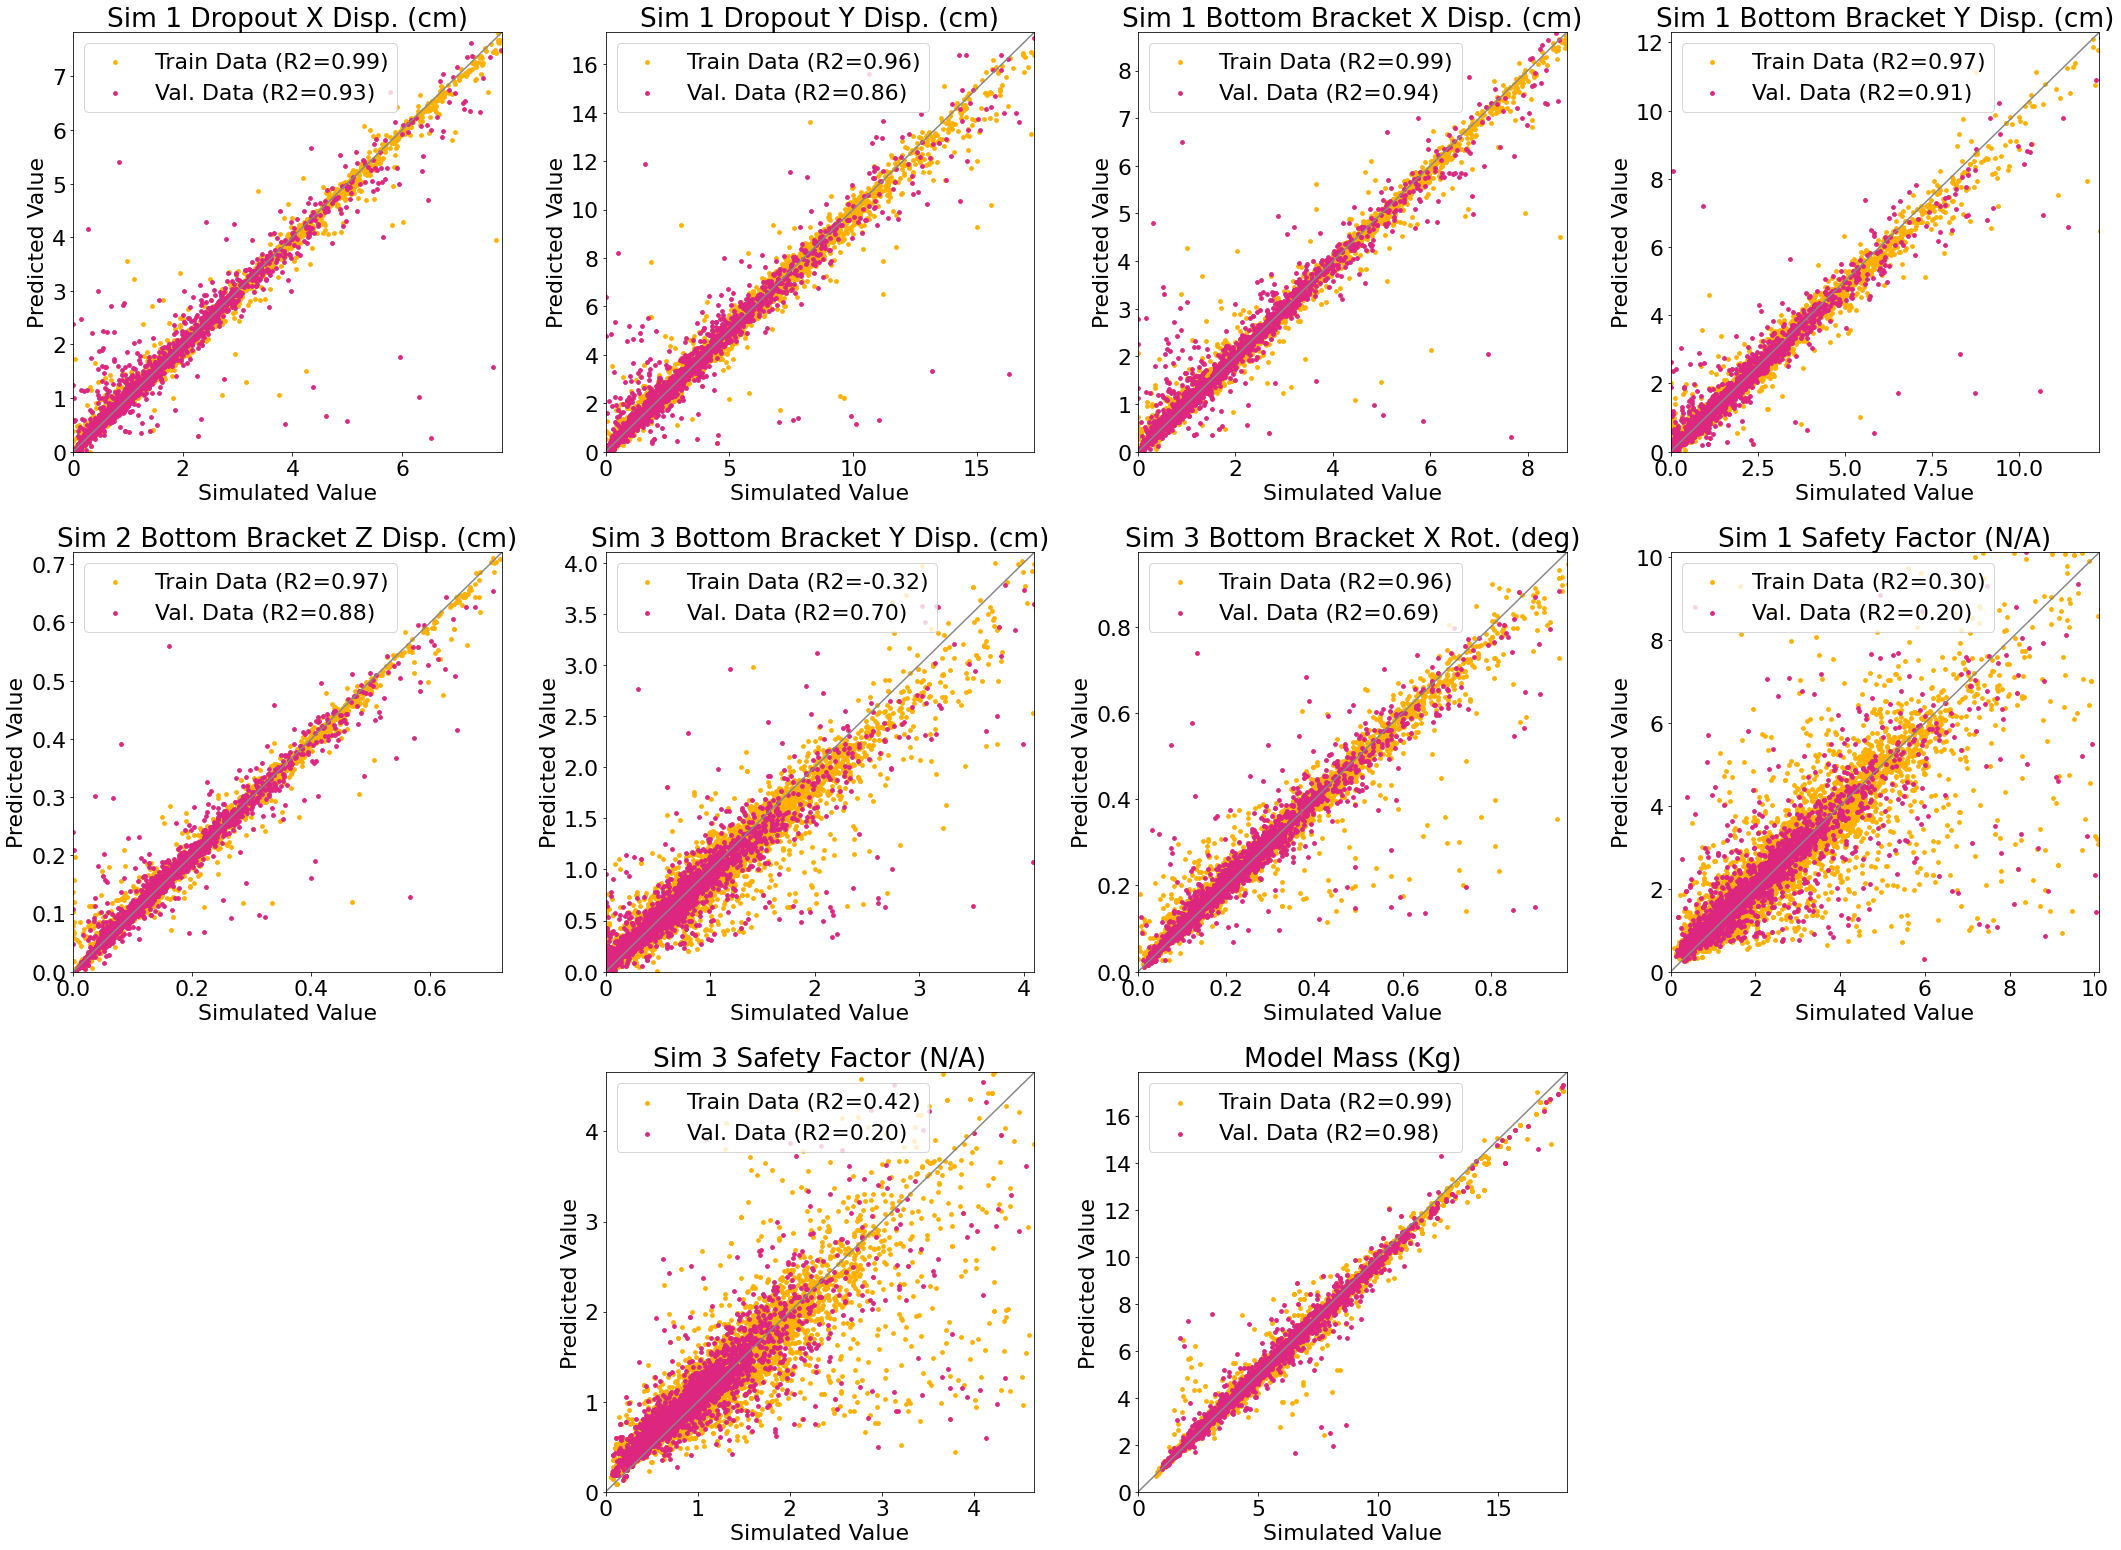

In [94]:
def plotperf(y_train, y_pred_train, y_val, y_pred_val, names): # Plot predictions vs target values
    fig = plt.figure(figsize=(30,22))
    plt.rcParams.update({'font.size': 22})
    size=14
    linewidth=4
    x_subplots=4
    y_subplots=3
    scales=[100,100,100,100,100,100,180/np.pi,1,1,1]
    units=["cm", "cm", "cm", "cm", "cm", "cm", "deg", "N/A", "N/A", "Kg"]
    for i in range(len(y_val[0,:])):
        scale=scales[i]
        sp=i+1
        if i>=8:
            sp=i+2
        ax = fig.add_subplot(y_subplots, x_subplots, sp)
        minval = min([y_pred_val[:,i].min(), y_pred_train[:,i].min()])
        maxval = max([np.partition(y_pred_val[:,i].flatten(), -2)[-10], np.partition(y_pred_val[:,i].flatten(), -2)[-10]])
        plt.xlim([0, maxval*scale*1.1])
        plt.ylim([0, maxval*scale*1.1])
        trainR2=sklearn.metrics.r2_score(y_train[:,i], y_pred_train[:,i])
        valR2=sklearn.metrics.r2_score(y_val[:,i], y_pred_val[:,i])
        plt.scatter(y_train[:,i]*scale, y_pred_train[:,i]*scale, c="#FFB000", s=size, label="Train Data (R2=" + "{:.2f}".format(trainR2) + ")")
        plt.scatter(y_val[:,i]*scale, y_pred_val[:,i]*scale, c="#DC267F", s=size, label="Val. Data (R2=" + "{:.2f}".format(valR2) + ")")
        plt.legend(loc='upper left')
        plt.title(names[i] + " (" + units[i] + ")")
        ax=add_identity(ax)
        ax.set_xlabel("Simulated Value")
        ax.set_ylabel("Predicted Value")
#         ax.spines["top"].set_visible(False)
#         ax.spines["right"].set_visible(False)
#         ax.spines["left"].set_visible(False)
#         ax.spines["bottom"].set_visible(False)
    fig.tight_layout()
    

def add_identity(axes, *line_args, **line_kwargs): #Helper function to draw target line on plots
    identity, = axes.plot([], [], *line_args, **line_kwargs, c="#888888")
    def callback(axes):
        low_x, high_x = axes.get_xlim()
        low_y, high_y = axes.get_ylim()
        low = max(low_x, low_y)
        high = min(high_x, high_y)
        identity.set_data([low, high], [low, high])
    callback(axes)
    axes.callbacks.connect('xlim_changed', callback)
    axes.callbacks.connect('ylim_changed', callback)
    return axes
# plotperf(y_train.values, train_predictions.values, y_test.values, predictions.values, names)
plotperf(y_train, train_predictions, y_test, predictions, names)

In [ ]:
indices=[]
for i in range(np.shape(y_test)[0]):
    if predictions[i,7]>8:
        if y_test[i,7]<4:
            indices.append(i)
x_isc=xscaler.inverse_transform(x_test)
x_isc=pd.DataFrame(x_isc, index=x_test.index, columns=x_test.columns)
display(x_isc.iloc[indices])
# indices=[]
# for i in range(np.shape(y_train)[0]):
#     if train_predictions[i,7]>8:
#         if y_train[i,7]<4:
#             indices.append(i)
# x_isc=xscaler.inverse_transform(x_train)
# x_isc=pd.DataFrame(x_isc, index=x_train.index, columns=x_train.columns)
# display(x_isc.iloc[indices])

# indices=[]
# for i in range(np.shape(y_train)[0]):
#     if y_train[i,7]>8:
#         if train_predictions[i,7]>4:
#             indices.append(i)
# x_isc=xscaler.inverse_transform(x_train)
# x_isc=pd.DataFrame(x_isc, index=x_train.index, columns=x_train.columns)
# display(x_isc.iloc[indices])

indices=[]
for i in range(np.shape(y_train)[0]):
    if train_predictions[i,7]>8:
        if y_train[i,7]>4:
            indices.append(i)
x_isc=xscaler.inverse_transform(x_train)
x_isc=pd.DataFrame(x_isc, index=x_train.index, columns=x_train.columns)
display(x_isc.iloc[indices])

In [94]:
x_samp=x_orig.loc[3591:3602]
# print(x_samp)
x_samp_sc=xscaler.transform(x_samp)
x_samp=pd.DataFrame(x_samp_sc, index=x_samp.index, columns=x_samp.columns)
preds_samp=predictor.predict(x_samp)
print(preds_samp)
preds_samp_sc=yscaler.inverse_transform(preds_samp)
preds_samp=pd.DataFrame(preds_samp_sc, index=preds_samp.index, columns=preds_samp.columns)
print(preds_samp)

      Sim 1 Dropout X Disp.  Sim 1 Dropout Y Disp.  \
3591               1.021963              -0.044340   
3592               0.510760              -0.341408   
3593              -0.918337              -0.753126   
3594               3.664814               0.862120   
3595               1.998607               0.235974   
3596               2.150040              -0.139655   
3597               0.598653              -0.294154   
3598               1.506702               0.155591   
3599               1.234638              -0.040325   
3600               1.782315               0.252798   
3601               0.758384              -0.193837   

      Sim 1 Bottom Bracket X Disp.  Sim 1 Bottom Bracket Y Disp.  \
3591                      1.100903                      0.350504   
3592                      0.432683                     -0.152181   
3593                     -0.910639                     -0.833486   
3594                      3.170185                      1.517766   
3595       

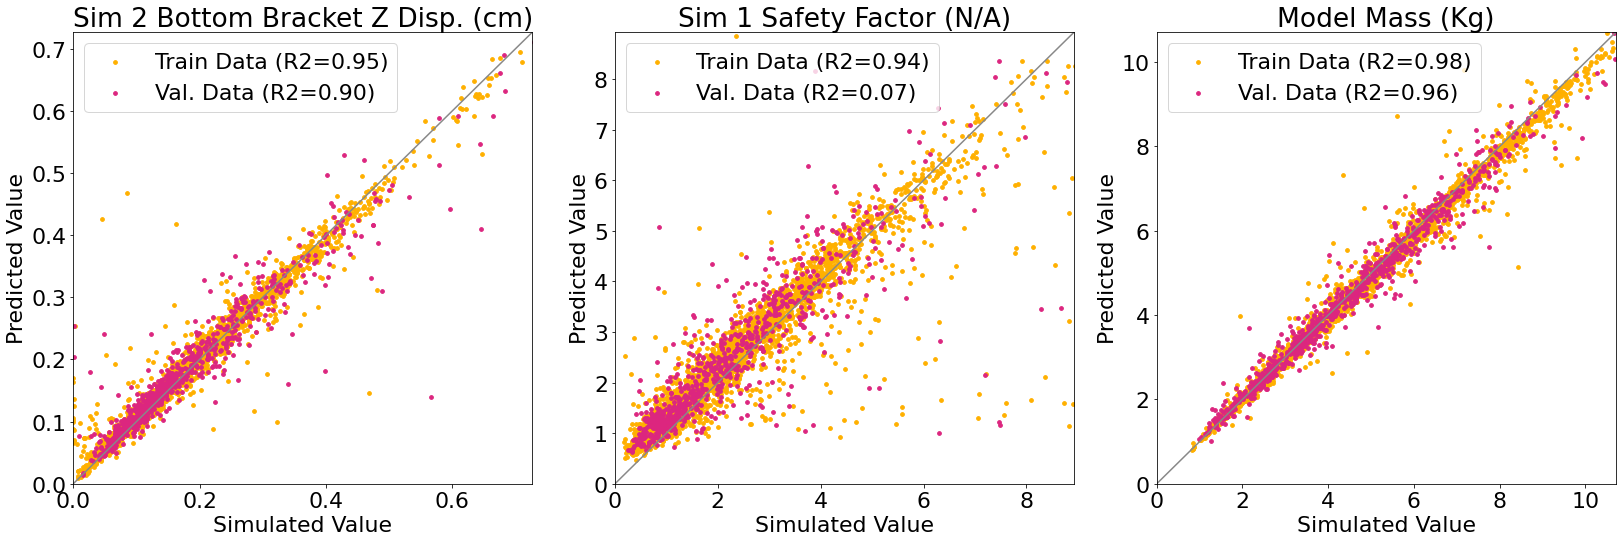

In [76]:
def plotperf2(y_train, y_pred_train, y_val, y_pred_val, names): # Plot predictions vs target values
    fig = plt.figure(figsize=(23,8))
    plt.rcParams.update({'font.size': 22})
    size=14
    linewidth=4
    x_subplots=3
    y_subplots=1
    scales=[100,100,100,100,100,100,180/np.pi,1,1,1]
    units=["cm", "cm", "cm", "cm", "cm", "cm", "deg", "N/A", "N/A", "Kg"]
    sp=0
    for i in range(len(y_val[0,:])):
        if i in [4,7,9]:
            scale=scales[i]
            sp=sp+1
            ax = fig.add_subplot(y_subplots, x_subplots, sp)
            np.partition(y_pred_val[:,i].flatten(), -2)[-10]
            minval = min([y_pred_val[:,i].min(), y_pred_train[:,i].min()])
            maxval = max([np.partition(y_pred_val[:,i].flatten(), -2)[-5], np.partition(y_pred_val[:,i].flatten(), -2)[-5]])
            plt.xlim([0, maxval*scale*1.1])
            plt.ylim([0, maxval*scale*1.1])
            trainR2=sklearn.metrics.r2_score(y_train[:,i], y_pred_train[:,i])
            valR2=sklearn.metrics.r2_score(y_val[:,i], y_pred_val[:,i])
            plt.scatter(y_train[:,i]*scale, y_pred_train[:,i]*scale, c="#FFB000", s=size, label="Train Data (R2=" + "{:.2f}".format(trainR2) + ")")
            plt.scatter(y_val[:,i]*scale, y_pred_val[:,i]*scale, c="#DC267F", s=size, label="Val. Data (R2=" + "{:.2f}".format(valR2) + ")")
            plt.legend(loc='upper left')
            plt.title(names[i] + " (" + units[i] + ")")
            ax=add_identity(ax)
            ax.set_xlabel("Simulated Value")
            ax.set_ylabel("Predicted Value")
    fig.tight_layout()
    

def add_identity(axes, *line_args, **line_kwargs): #Helper function to draw target line on plots
    identity, = axes.plot([], [], *line_args, **line_kwargs, c="#888888")
    def callback(axes):
        low_x, high_x = axes.get_xlim()
        low_y, high_y = axes.get_ylim()
        low = max(low_x, low_y)
        high = min(high_x, high_y)
        identity.set_data([low, high], [low, high])
    callback(axes)
    axes.callbacks.connect('xlim_changed', callback)
    axes.callbacks.connect('ylim_changed', callback)
    return axes
# plotperf2(y_train.values, train_predictions.values, y_test.values, predictions.values, names)
plotperf2(y_train, train_predictions, y_test, predictions, names)